## Dataset Preparation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import re
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = pd.read_json("./data/bias_articles_train.json")
dev_df = pd.read_json("./data/bias_articles_dev.json")
test_df = pd.read_json("./data/bias_articles_test.json")

In [3]:
# drop id=175 (all values are NaN)
train_df = train_df.dropna().reset_index()

<AxesSubplot:xlabel='bias', ylabel='count'>

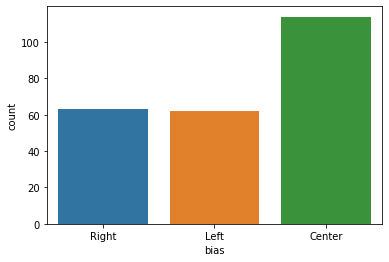

In [4]:
def data_distribution(df):
    return sns.countplot(x='bias', data=df)

# "Center" class proportion is almost 2:1 compared to the others.
data_distribution(train_df)

In [5]:
def data_cleaning(text):
    # Remove symbols and punctuations & apply loxer() to string
    formatted_text = re.sub(r"[^\w\s]", " ", text).lower()

    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = [i for i in formatted_text.split() if not i in stopwords]
    
    # Stemming tokens
    word_stem = [PorterStemmer().stem(word) for word in words]
    
    return (" ".join(word_stem))

def column_concat(df, col1, col2):
    return (df[col1] + ' ' + df[col2])
    
train_df['title_body'] = [data_cleaning(i) for i in column_concat(train_df, 'title', 'body')]
dev_df['title_body'] = [data_cleaning(i) for i in column_concat(dev_df, 'title', 'body')]
test_df['title_body'] = [data_cleaning(i) for i in column_concat(test_df, 'title', 'body')]

In [6]:
train_x, dev_x, test_x = train_df['title_body'], dev_df['title_body'], test_df['title_body']
train_y, dev_y = LabelEncoder().fit_transform(train_df['bias']), LabelEncoder().fit_transform(dev_df['bias'])

# Feature Engineering & Model Training & Fine Tuning

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

## Naive Bayes

#### Training

In [8]:
NB_pipe = Pipeline([
        ('cv', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('nb_clf', MultinomialNB())])

NB_pipe.fit(train_x, train_y)

Pipeline(steps=[('cv', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('nb_clf', MultinomialNB())])

#### Fine tuning

In [9]:
parameters = {'cv__max_df': (0.25, 0.5, 0.75, 1.0),
              'cv__analyzer': ['word', 'char'],
              'cv__ngram_range': [(1, 3), (2, 3), (1, 4)],
              'tfidf__norm': ('l1', 'l2'),
              'tfidf__use_idf': (True, False)}

NV_gs = GridSearchCV(NB_pipe, parameters, n_jobs=-1, verbose=3)
NV_gs = NV_gs.fit(train_x, train_y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [10]:
NV_gs.best_params_

{'cv__analyzer': 'word',
 'cv__max_df': 0.25,
 'cv__ngram_range': (1, 3),
 'tfidf__norm': 'l1',
 'tfidf__use_idf': True}

In [11]:
NV_gs.best_score_

0.4769503546099291

#### Prediction & Evaluation (with best params)

In [12]:
best_NB_pipe = Pipeline([
        ('cv', CountVectorizer(analyzer='word', max_df=0.25, ngram_range=(1,3))),
        ('tfidf', TfidfTransformer(norm='l1', use_idf=True)),
        ('nb_clf', MultinomialNB())])

best_NB_pipe.fit(train_x, train_y)

Pipeline(steps=[('cv', CountVectorizer(max_df=0.25, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer(norm='l1')),
                ('nb_clf', MultinomialNB())])

In [13]:
NB_pred = best_NB_pipe.predict(dev_x)
print(NB_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
print(classification_report(NB_pred, dev_y))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        30
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.50        30
   macro avg       0.33      0.17      0.22        30
weighted avg       1.00      0.50      0.67        30



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM

#### Training

In [15]:
SVM_pipe = Pipeline([
        ('cv', CountVectorizer()),
        ('svm_clf', SVC(kernel='poly', degree=3))])

SVM_pipe.fit(train_x, train_y)

Pipeline(steps=[('cv', CountVectorizer()), ('svm_clf', SVC(kernel='poly'))])

#### Fine tuning

In [16]:
parameters = {'cv__max_df': (0.5, 0.75),
              'cv__analyzer': ['word', 'char'],
              'svm_clf__C': (0.5, 0.75, 1, 1.25, 1.5),
              'svm_clf__class_weight': [None, 'balanced'],
              'svm_clf__gamma': ['auto', 'scale']
}

SVM_gs = GridSearchCV(SVM_pipe, parameters, n_jobs=-1, verbose=3)
SVM_gs = SVM_gs.fit(train_x, train_y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [17]:
SVM_gs.best_params_

{'cv__analyzer': 'char',
 'cv__max_df': 0.75,
 'svm_clf__C': 1.25,
 'svm_clf__class_weight': None,
 'svm_clf__gamma': 'scale'}

In [18]:
SVM_gs.best_score_

0.4812943262411348

#### Prediction & Evaluation (with best params)

In [19]:
best_SVM_pipe = Pipeline([
        ('cv', CountVectorizer(analyzer='char', max_df=0.75)),
        ('svm_clf', SVC(kernel='poly', degree=3, gamma='scale', C=1.25))])

best_SVM_pipe.fit(train_x, train_y)

Pipeline(steps=[('cv', CountVectorizer(analyzer='char', max_df=0.75)),
                ('svm_clf', SVC(C=1.25, kernel='poly'))])

In [20]:
SVM_pred = best_SVM_pipe.predict(dev_x)
print(SVM_pred)

[1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0]


In [21]:
print(classification_report(SVM_pred, dev_y))

              precision    recall  f1-score   support

           0       0.80      0.46      0.59        26
           1       0.00      0.00      0.00         2
           2       0.14      0.50      0.22         2

    accuracy                           0.43        30
   macro avg       0.31      0.32      0.27        30
weighted avg       0.70      0.43      0.52        30



## Random Forest

#### Training (Random Forest on Count Vectors)

In [22]:
RF_cv_pipe = Pipeline([
        ('cv', CountVectorizer()),
        ('rf_clf', RandomForestClassifier())])

RF_cv_pipe.fit(train_x, train_y)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf_clf', RandomForestClassifier())])

#### Fine Tuning (Random Forest on Count Vectors)

In [23]:
parameters = {'cv__max_df': (0.5, 0.75, 1.0),
              'cv__analyzer': ['word', 'char'],
              'rf_clf__max_features': ['auto', 'sqrt'],
              'rf_clf__max_depth': (4,6,8,10),
              'rf_clf__class_weight': [None, 'balanced']
}

RF_cv_gs = GridSearchCV(RF_cv_pipe, parameters, n_jobs=-1, verbose=3)
RF_cv_gs = RF_cv_gs.fit(train_x, train_y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [24]:
RF_cv_gs.best_params_

{'cv__analyzer': 'word',
 'cv__max_df': 0.5,
 'rf_clf__class_weight': None,
 'rf_clf__max_depth': 10,
 'rf_clf__max_features': 'auto'}

In [25]:
RF_cv_gs.best_score_

0.48537234042553196

#### Prediction & Evaluation (with best params - Random Forest on Count Vectors)

In [26]:
best_RF_cv_pipe = Pipeline([
        ('cv', CountVectorizer(max_df=0.75, analyzer='word')),
        ('rf_clf', RandomForestClassifier(class_weight='balanced', max_depth=10, max_features='auto'))])

best_RF_cv_pipe.fit(train_x, train_y)

Pipeline(steps=[('cv', CountVectorizer(max_df=0.75)),
                ('rf_clf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_depth=10))])

In [27]:
RF_cv_pred = best_RF_cv_pipe.predict(dev_x)
print(RF_cv_pred)

[2 0 0 2 0 0 0 0 0 2 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]


In [28]:
print(classification_report(RF_cv_pred, dev_y))

              precision    recall  f1-score   support

           0       0.87      0.52      0.65        25
           1       0.00      0.00      0.00         0
           2       0.14      0.20      0.17         5

    accuracy                           0.47        30
   macro avg       0.34      0.24      0.27        30
weighted avg       0.75      0.47      0.57        30



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Training (Random Forest on TF IDF Vectors, Ngram Level)

In [29]:
RF_tfidf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(2, 3), analyzer='word')),
        ('rf_clf', RandomForestClassifier())])

RF_tfidf_pipe.fit(train_x, train_y)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 3))),
                ('rf_clf', RandomForestClassifier())])

#### Fine Tuning (Random Forest on TF IDF Vectors, Ngram Level)

In [30]:
parameters = {'tfidf__max_df': (0.25, 0.5, 0.75),
              'rf_clf__max_features': ['auto', 'sqrt'],
              'rf_clf__class_weight': [None, 'balanced'],
              'rf_clf__max_depth': (4,6,8,10,12)
}

RF_tfidf_gs = GridSearchCV(RF_tfidf_pipe, parameters, n_jobs=-1, verbose=3)
RF_tfidf_gs= RF_tfidf_gs.fit(train_x, train_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [31]:
RF_tfidf_gs.best_params_

{'rf_clf__class_weight': 'balanced',
 'rf_clf__max_depth': 10,
 'rf_clf__max_features': 'auto',
 'tfidf__max_df': 0.5}

In [32]:
RF_tfidf_gs.best_score_

0.502127659574468

#### Prediction & Evaluation (with best params - Random Forest on TF IDF Vectors, Ngram Level))

In [33]:
best_RF_tfidf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.75)),
        ('rf_clf', RandomForestClassifier(class_weight='balanced', max_features='auto', max_depth=12))])

best_RF_tfidf_pipe.fit(train_x, train_y)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.75)),
                ('rf_clf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_depth=12))])

In [34]:
RF_tfidf_pred = best_RF_tfidf_pipe.predict(dev_x)
print(RF_tfidf_pred)

[0 0 0 2 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0]


In [35]:
print(classification_report(RF_tfidf_pred, dev_y))

              precision    recall  f1-score   support

           0       0.87      0.52      0.65        25
           1       0.00      0.00      0.00         0
           2       0.29      0.40      0.33         5

    accuracy                           0.50        30
   macro avg       0.38      0.31      0.33        30
weighted avg       0.77      0.50      0.60        30



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Extereme Gradient Boosting

#### Training (XGB on TF IDF Vectors, Ngram Level)

In [36]:
XGB_tfidf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='char')),
        ('xgb_clf', XGBClassifier(use_label_encoder=False))])

XGB_tfidf_pipe.fit(train_x, train_y)

[22:55:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char')),
                ('xgb_clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1

#### Fine Tuning (XGB on TF IDF Vectors, Ngram Level)

In [37]:
parameters = {'tfidf__max_df': (0.25, 0.5, 0.75),
              'tfidf__ngram_range': [(1,2), (2,3), (1,4)]
}
XGB_tfidf_gs = GridSearchCV(XGB_tfidf_pipe, parameters, n_jobs=-1, verbose=3)
XGB_tfidf_gs= XGB_tfidf_gs.fit(train_x, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[22:58:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [38]:
XGB_tfidf_gs.best_params_

{'tfidf__max_df': 0.25, 'tfidf__ngram_range': (1, 4)}

In [39]:
XGB_tfidf_gs.best_score_

0.5018617021276596

#### Prediction & Evaluation (with best params - XGB on TF IDF Vectors, Ngram Level))

In [40]:
best_XGB_tfidf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 4), max_df=0.25)),
        ('xgb_clf', XGBClassifier(use_label_encoder=False))])

best_XGB_tfidf_pipe.fit(train_x, train_y)

[22:58:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.25,
                                 ngram_range=(1, 4))),
                ('xgb_clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='ex

In [41]:
best_XGB_tfidf_pred = best_XGB_tfidf_pipe.predict(dev_x)
print(best_XGB_tfidf_pred)

[1 2 0 0 2 0 2 0 2 2 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 2 0 0]


In [42]:
print(classification_report(best_XGB_tfidf_pred, dev_y))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59        19
           1       0.25      0.40      0.31         5
           2       0.14      0.17      0.15         6

    accuracy                           0.43        30
   macro avg       0.35      0.36      0.35        30
weighted avg       0.49      0.43      0.45        30



## Test set label prediction

In [43]:
best_XGB_tfidf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 4), max_df=0.25)),
        ('xgb_clf', XGBClassifier(use_label_encoder=False))])

best_XGB_tfidf_pipe.fit(train_x, train_y)

[22:58:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.25,
                                 ngram_range=(1, 4))),
                ('xgb_clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='ex

In [44]:
XGB_tfidf_pred = best_XGB_tfidf_pipe.predict(test_x)
print(XGB_tfidf_pred)

[0 1 0 0 1 0 1 1 1 0 2 0 0 0 0 1 0 0 0 1 0 1 0 2 0 1 0 0 0 0]


In [45]:
test_df['bias_predicted'] = XGB_tfidf_pred
test_df["bias_predicted"].replace({0: "Center", 2: "Right", 1: "Left"}, inplace=True)

In [46]:
test_df

,body,id,title,title_body,bias_predicted
0,WASHINGTON -- The U.S. Attorney’s office in N...,270,U.S. Attorney Subpoenas Chris Christie Campaig...,u attorney subpoena chri christi campaign docu...,Center
1,"Roger Stone, an eccentric longtime Republican...",271,Trump Associate Roger Stone Indicted In Muelle...,trump associ roger stone indict mueller invest...,Left
2,"Democrats’ landmark campaign finance, voting ...",272,House Democrats Pass Landmark Campaign Finance...,hous democrat pass landmark campaign financ vo...,Center
3,WASHINGTON -- President Barack Obama on Frida...,273,"Obama Defends NSA Programs, Says Congress Knew...",obama defend nsa program say congress knew sur...,Center
4,WASHINGTON — The lawmakers trotted from their...,274,"Shooting Brings Rare Comity to the Capital, bu...",shoot bring rare comiti capit last washington ...,Left
5,"Susan Rice, President Barack Obama's national...",275,Susan Rice: Netanyahu Visit 'Destructive' To U...,susan rice netanyahu visit destruct u israel r...,Center
6,"WASHINGTON — The special counsel, Robert S. M...",276,"Indicting Roger Stone, Mueller Shows Link Betw...",indict roger stone mueller show link trump cam...,Left
7,"Mike Huckabee, a former Republican governor o...",277,Mike Huckabee on the Issues,mike huckabe issu mike huckabe former republic...,Left
8,WASHINGTON ― President Donald Trump’s offer t...,278,Trump's 'Compromise' Immigration Offer To Demo...,trump compromis immigr offer democrat includ m...,Left
9,The Obama administration found itself defendi...,279,Obama administration defends 2nd mass surveill...,obama administr defend 2nd mass surveil projec...,Center


In [47]:
test_df.to_csv('data/pred/bias_articles_test_pred_v3.csv',
               columns=['bias_predicted', 'id', 'title', 'body'],
               index=False)